In [142]:
from collections import defaultdict
import datetime as dt
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet50
from effdet.data import create_loader

from ml_carbucks.utils.coco import CocoStatsEvaluator, create_dataset_custom
from ml_carbucks.utils.inference import plot_img_pred as ppp

IMG_SIZE = 320
BATCH_SIZE = 8
NUM_CLASSES = 3
RUNTIME = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = "resnet50"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CenterNetHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Shared conv
        self.shared = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Separate heads
        self.heatmap = nn.Conv2d(256, num_classes, 1)
        self.wh = nn.Conv2d(256, 2, 1)
        self.offset = nn.Conv2d(256, 2, 1)
        self._init_weights()

    def _init_weights(self):
        # Heatmap bias init -> lower confidence initially
        self.heatmap.bias.data.fill_(-2.19)  # type: ignore

    def forward(self, x):
        feat = self.shared(x)
        return {
            "heatmap": torch.sigmoid(self.heatmap(feat)),
            "wh": self.wh(feat),
            "offset": self.offset(feat),
        }

class CenterNet(nn.Module):
    def __init__(self, num_classes=3, backbone_name="resnet50", pretrained=True):
        super().__init__()

        assert (
            backbone_name == "resnet50"
        ), "Only resnet50 backbone is supported in this implementation."

        backbone = resnet50(weights="IMAGENET1K_V1" if pretrained else None)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # C5 feature map
        self.head = CenterNetHead(2048, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        out = self.head(feat)
        return out

def focal_loss(pred, gt):
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    neg_weights = torch.pow(1 - gt, 4)

    pred = torch.clamp(pred, 1e-6, 1 - 1e-6)
    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    return -(pos_loss + neg_loss) / (num_pos + 1e-4)

def compute_loss(preds, targets):
    hm_loss = focal_loss(preds["heatmap"], targets["heatmap"])
    wh_loss = F.l1_loss(preds["wh"], targets["wh"], reduction="mean")
    off_loss = F.l1_loss(preds["offset"], targets["offset"], reduction="mean")
    return hm_loss + wh_loss + off_loss, (hm_loss, wh_loss, off_loss)

def decode_predictions(preds, conf_thresh=0.5, stride=32, K=100, nms_kernel=3):
    """
    preds: dict with 'heatmap', 'wh', 'offset'
    conf_thresh: minimum confidence to keep a detection
    stride: scaling factor from heatmap to original image
    K: max number of detections per class
    nms_kernel: size of max pooling for NMS
    """
    heatmap, wh, offset = preds["heatmap"], preds["wh"], preds["offset"]
    batch, cat, height, width = heatmap.size()

    preds_device = heatmap.device
    # --- NMS on heatmap ---
    pooled = F.max_pool2d(
        heatmap, kernel_size=nms_kernel, stride=1, padding=nms_kernel // 2
    )
    keep = (pooled == heatmap).float()
    heatmap = heatmap * keep

    boxes_list = []
    scores_list = []
    labels_list = []

    for b in range(batch):
        for c in range(cat):
            hm_flat = heatmap[b, c].view(-1)
            topk_scores, topk_inds = torch.topk(hm_flat, K)
            topk_mask = topk_scores > conf_thresh
            if topk_mask.sum() == 0:
                continue

            topk_scores = topk_scores[topk_mask]
            topk_inds = topk_inds[topk_mask]

            ys = (topk_inds // width).float()
            xs = (topk_inds % width).float()

            w = wh[b, 0].view(-1)[topk_inds]
            h = wh[b, 1].view(-1)[topk_inds]

            off_x = offset[b, 0].view(-1)[topk_inds]
            off_y = offset[b, 1].view(-1)[topk_inds]

            xs = xs + off_x
            ys = ys + off_y

            x1 = (xs - w / 2) * stride
            y1 = (ys - h / 2) * stride
            x2 = (xs + w / 2) * stride
            y2 = (ys + h / 2) * stride

            boxes = torch.stack([x1, y1, x2, y2], dim=-1)
            boxes_list.append(boxes)
            scores_list.append(topk_scores)
            labels_list.append(torch.full_like(topk_scores, c, dtype=torch.int))

    if len(boxes_list) == 0:
        return (
            torch.empty((0, 4)).to(preds_device),
            torch.empty((0,)).to(preds_device),
            torch.empty((0,), dtype=torch.int).to(preds_device),
        )

    boxes = torch.cat(boxes_list, dim=0)
    scores = torch.cat(scores_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    # --- apply standard NMS ---
    keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    return boxes, scores, labels

def encode_targets(boxes, labels, output_size, num_classes, stride):
    heatmap = torch.zeros((num_classes, *output_size), device=device)
    wh = torch.zeros((2, *output_size), device=device)
    offset = torch.zeros((2, *output_size), device=device)

    for box, cls in zip(boxes, labels):
        x1, y1, x2, y2 = box

        cx = (x1 + x2) / 2 / stride
        cy = (y1 + y2) / 2 / stride
        w = (x2 - x1) / stride
        h = (y2 - y1) / stride
        cx_int, cy_int = int(cx), int(cy)

        # mark the heatmap (you can add a small gaussian, here just set 1)
        heatmap[cls, cy_int, cx_int] = 1
        wh[:, cy_int, cx_int] = torch.tensor([w, h], device=device)
        offset[:, cy_int, cx_int] = torch.tensor(
            [cx - cx_int, cy - cy_int], device=device
        )

    return {"heatmap": heatmap, "wh": wh, "offset": offset}



In [152]:
DATASET_LIMIT = 1000
train_dataset = create_dataset_custom(
    name="train",
    img_dir=Path("/home/bachelor/ml-carbucks/data/car_dd/images/train"),
    ann_file=Path("/home/bachelor/ml-carbucks/data/car_dd/instances_train.json"),
    limit=DATASET_LIMIT,
)

train_loader = create_loader(
    train_dataset,
    input_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    use_prefetcher=True,
    num_workers=4,
    pin_mem=False,
)

val_dataset = create_dataset_custom(
    name="val",
    img_dir=Path("/home/bachelor/ml-carbucks/data/car_dd/images/val"),
    ann_file=Path("/home/bachelor/ml-carbucks/data/car_dd/instances_val.json"),
    limit=DATASET_LIMIT,
)

val_loader = create_loader(
    val_dataset,
    input_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    use_prefetcher=True,
    num_workers=4,
    pin_mem=False,
)

val_evaluator = CocoStatsEvaluator(dataset=val_dataset, pred_yxyx=False)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [153]:
EPOCHS = 15

model = CenterNet(num_classes=3, backbone_name=MODEL_NAME, pretrained=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Determine output size / stride once
dummy_input = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    pred = model(dummy_input)
target_h, target_w = pred["heatmap"].shape[2], pred["heatmap"].shape[3]
stride = IMG_SIZE // target_h


for epoch in range(EPOCHS):
    model.train()
    for imgs, targets in tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} | Training batches"
    ):
        imgs = imgs.to(device)
 
        split_targets = [
            {"boxes": targets["bbox"][i], "labels": targets["cls"][i].long()}
            for i in range(imgs.shape[0])
        ]
        batch_targets = [
            encode_targets(
                t["boxes"], t["labels"], (target_h, target_w), NUM_CLASSES, stride
            )
            for t in split_targets
        ]
        batch_hm = torch.stack([bt["heatmap"] for bt in batch_targets])
        batch_wh = torch.stack([bt["wh"] for bt in batch_targets])
        batch_off = torch.stack([bt["offset"] for bt in batch_targets])

        # Forward + backward
        pred = model(imgs)
        loss, (hm_loss, wh_loss, off_loss) = compute_loss(
            pred, {"heatmap": batch_hm, "wh": batch_wh, "offset": batch_off}
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        


Epoch 1/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.05it/s]
Epoch 2/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.04it/s]
Epoch 3/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.04it/s]
Epoch 4/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.04it/s]
Epoch 5/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 6/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.03it/s]
Epoch 7/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 8/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 9/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 10/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 11/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 12/15 | Training batches: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]
Epoch 13/15 | Training ba

In [4]:
def gather_feature(fmap, index, mask=None, use_transform=False):
    if use_transform:
        # change a (N, C, H, W) tenor to (N, HxW, C) shape
        batch, channel = fmap.shape[:2]
        fmap = fmap.view(batch, channel, -1).permute((0, 2, 1)).contiguous()

    dim = fmap.size(-1)
    index = index.unsqueeze(len(index.shape)).expand(*index.shape, dim)
    fmap = fmap.gather(dim=1, index=index)
    if mask is not None:
        # this part is not called in Res18 dcn COCO
        mask = mask.unsqueeze(2).expand_as(fmap)
        fmap = fmap[mask]
        fmap = fmap.reshape(-1, dim)
    return fmap

def pool_nms(hm, pool_size=3):
        pad = (pool_size - 1) // 2
        hm_max = F.max_pool2d(hm, pool_size, stride=1, padding=pad)
        keep = (hm_max == hm).float()
        return hm * keep

def topk_score( scores, K):
    batch, channel, height, width = scores.shape

    # get topk score and its index in every H x W(channel dim) feature map
    topk_scores, topk_inds = torch.topk(scores.reshape(batch, channel, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (topk_inds / width).int().float()
    topk_xs = (topk_inds % width).int().float()

    # get all topk in in a batch
    topk_score, index = torch.topk(topk_scores.reshape(batch, -1), K)
    # div by K because index is grouped by K(C x K shape)
    topk_clses = (index / K).int()
    topk_inds = gather_feature(topk_inds.view(batch, -1, 1), index).reshape(batch, K)
    topk_ys = gather_feature(topk_ys.reshape(batch, -1, 1), index).reshape(batch, K)
    topk_xs = gather_feature(topk_xs.reshape(batch, -1, 1), index).reshape(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

def decode_decode(img, pred_hm, pred_wh, pred_offset, topK=100, threshold=0.0):
    _, _, h, w = img.shape
    b, c, output_h, output_w = pred_hm.shape
    pred_hm = pool_nms(pred_hm)
    scores, index, clses, ys, xs = topk_score(pred_hm, K=topK)

    reg = gather_feature(pred_offset, index, use_transform=True)
    reg = reg.reshape(b, topK, 2)
    xs = xs.view(b, topK, 1) + reg[:, :, 0:1]
    ys = ys.view(b, topK, 1) + reg[:, :, 1:2]

    wh = gather_feature(pred_wh, index, use_transform=True)
    wh = wh.reshape(b, topK, 2)

    clses = clses.reshape(b, topK, 1).float()
    scores = scores.reshape(b, topK, 1)

    half_w, half_h = wh[..., 0:1] / 2, wh[..., 1:2] / 2
    bboxes = torch.cat([xs - half_w, ys - half_h, xs + half_w, ys + half_h], dim=2)

    detects = []
    for batch in range(b):
        mask = scores[batch].gt(threshold)

        batch_boxes = bboxes[batch][mask.squeeze(-1), :]
        # batch_boxes[:, [0, 2]] *= infos[batch]['raw_width'] / output_w
        # batch_boxes[:, [1, 3]] *= infos[batch]['raw_height'] / output_h
        batch_boxes[:, [0, 2]] *= w / output_w
        batch_boxes[:, [1, 3]] *= h / output_h

        batch_scores = scores[batch][mask]

        batch_clses = clses[batch][mask]
        # batch_clses = [CLASSES_NAME[int(cls.item())] for cls in batch_clses]


        # raise ValueError(
        #     f"batch_boxes: {batch_boxes.shape}, batch_scores: {batch_scores.shape}, batch_clses: {batch_clses.shape}"
        # )
        detects.append(
            torch.cat([
                batch_boxes,                    # [N, 4]
                batch_scores.unsqueeze(1),      # [N, 1]
                batch_clses.unsqueeze(1)        # [N, 1]
            ], dim=1)                           # → [N, 6]        ])
        )

    return detects


In [162]:
from ml_carbucks.utils.zxing import ctdet_decode
from torchmetrics.detection.mean_ap import MeanAveragePrecision
model.eval()
metric = MeanAveragePrecision()
all_gts = []
all_preds = []
with torch.no_grad():
    for val_imgs, val_targets in tqdm(train_loader):
        val_preds = model(val_imgs)

        

        for i in range(val_imgs.shape[0]):
            val_boxes_i, val_scores_i, val_labels_i = decode_predictions(
                {k: v[i:i+1] for k, v in val_preds.items()}, conf_thresh=0.5, stride=stride, K=100,
            )

            gt_boxes = val_targets['bbox'][i].cpu()
            gt_labels = val_targets['cls'][i].cpu()
            # filter out -1 labels (no object)
            mask = gt_labels != -1
            gt_boxes = gt_boxes[mask]
            gt_labels = gt_labels[mask]
            all_gts.append({
                'boxes':  gt_boxes,
                'labels': gt_labels.long()
            })
            if val_boxes_i.shape[0] == 0:
                all_preds.append({
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),
                    'scores': torch.zeros((0,), dtype=torch.float32),
                    'labels': torch.zeros((0,), dtype=torch.int64)
                })
            else:
                all_preds.append({
                    'boxes': val_boxes_i.cpu(),
                    'scores': val_scores_i.cpu(),
                    'labels': val_labels_i.cpu().long()
                })



        # val_detects = decode_decode(val_imgs, val_preds["heatmap"], val_preds["wh"], val_preds["offset"], topK=100, threshold=0.1)
        # for i in range(val_imgs.shape[0]):
        #     gt_boxes = val_targets['bbox'][i].cpu()
        #     gt_labels = val_targets['cls'][i].cpu()
        #     # filter out -1 labels (no object)
        #     mask = gt_labels != -1
        #     gt_boxes = gt_boxes[mask]
        #     gt_labels = gt_labels[mask]
        #     # print(f"gt_boxes: {gt_boxes}, gt_labels: {gt_labels}")
        #     all_gts.append({
        #         'boxes': gt_boxes,
        #         'labels': gt_labels.long()
        #     })
        #     if val_detects[i].shape[0] == 0:
        #         all_preds.append({
        #             'boxes': torch.zeros((0, 4), dtype=torch.float32),
        #             'scores': torch.zeros((0,), dtype=torch.float32),
        #             'labels': torch.zeros((0,), dtype=torch.int64)
        #         })
        #     else:
        #         all_preds.append({
        #             'boxes': val_detects[i][:, :4].cpu(),
        #             # 'boxes': gt_boxes,
        #             'scores': val_detects[i][:, 4].cpu(),
        #             # 'scores': torch.ones((gt_boxes.shape[0],), dtype=torch.float32),
        #             # 'labels': gt_labels
        #             'labels': val_detects[i][:, 5].cpu().long()
        #         })   


metric.update(all_preds, all_gts)
metric.compute()

100%|██████████| 125/125 [00:03<00:00, 34.31it/s]


{'map': tensor(0.0080),
 'map_50': tensor(0.0400),
 'map_75': tensor(0.0002),
 'map_small': tensor(0.0014),
 'map_medium': tensor(0.0090),
 'map_large': tensor(0.0115),
 'mar_1': tensor(0.0196),
 'mar_10': tensor(0.0239),
 'mar_100': tensor(0.0239),
 'mar_small': tensor(0.0067),
 'mar_medium': tensor(0.0302),
 'mar_large': tensor(0.0212),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2], dtype=torch.int32)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088453].


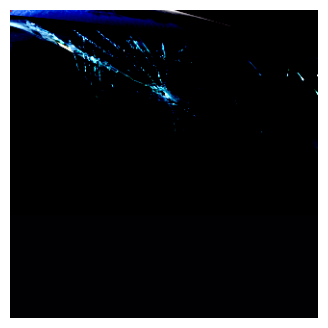

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].


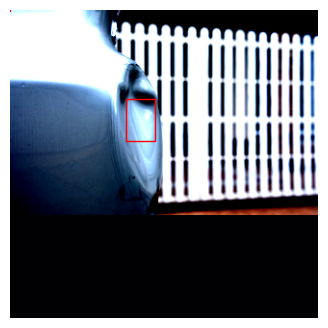

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4831374].


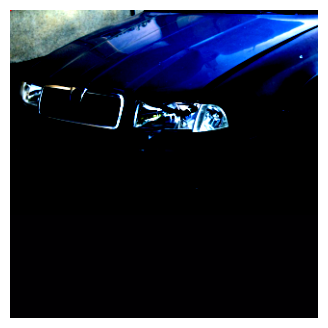

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.3611329].


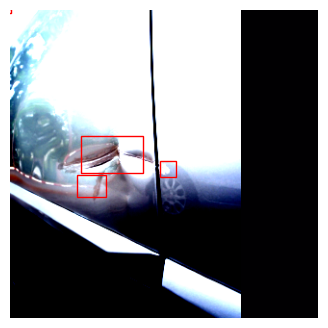

In [149]:
for ii in range(val_imgs.shape[0]): 
    ppp(
        val_imgs[ii], 
        # val_targets['bbox'][ii], 
        # val_boxes[ii],
        val_detects[ii][:, :4],
        # val_ct[ii][:, :4],
        coords='xyxy', 
        figsize=(4,4)
    ) # type: ignore

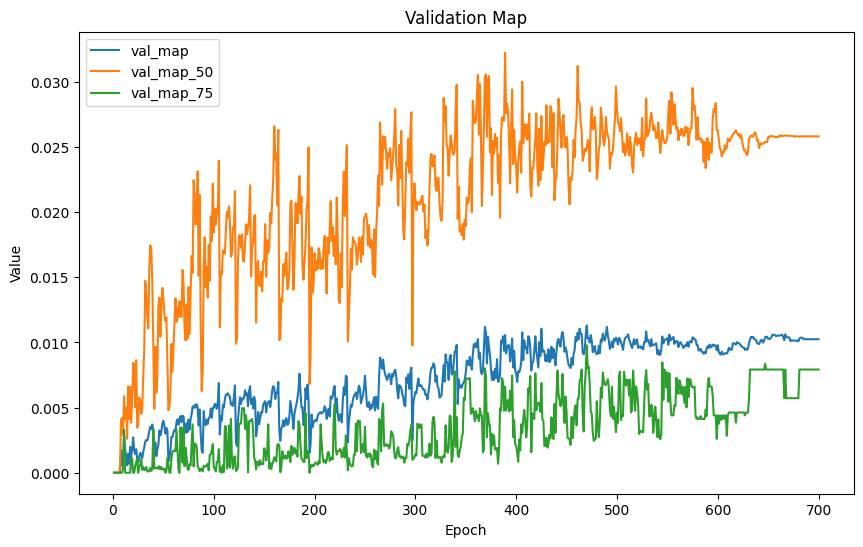

In [12]:
import pandas as pd
from matplotlib import pyplot as plt

csv_path = "/home/bachelor/ml-carbucks/training_resnet50_20251016_235123.csv"

df = pd.read_csv(csv_path)

plt.figure(figsize=(10,6))

# plot epoch on x axis and (val_map, val_map_50, val_map_75) on y axis
plt.plot(df['epoch'], df['val_map'], label='val_map')
plt.plot(df['epoch'], df['val_map_50'], label='val_map_50')
plt.plot(df['epoch'], df['val_map_75'], label='val_map_75')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Map')
plt.legend()
plt.savefig(f"{csv_path.split('/')[-1].split('.')[0]}_val_map.jpg")
plt.show()
